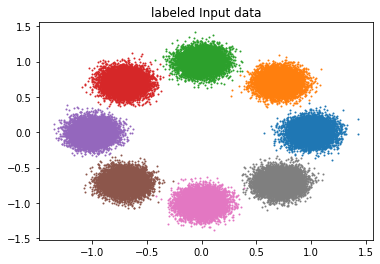

In [49]:
import numpy as np
import torch.nn as nn
import torch.nn.init
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional


class CustomDataSet(torch.utils.data.Dataset):

    def __init__(self, n_group, n_data):

        self.n_group = n_group
        self.n_data = n_data
        _data = np.random.randn(self.n_data, 2)
        _label = np.ndarray(self.n_data, dtype=np.int)
        _mu = []
        _sig = 0.1
        for k in range(n_group):
            _mu.append([np.cos(2.0 * np.pi * k / n_group), np.sin(2.0 * np.pi * k / n_group)])
        for i in range(n_data):
            _data[i][0] = _sig * _data[i][0] + _mu[i % n_group][0]
            _data[i][1] = _sig * _data[i][1] + _mu[i % n_group][1]
            _label[i] = i % n_group

        self.data = torch.as_tensor(_data, dtype=torch.float32)
        self.label = torch.as_tensor(_label, dtype=torch.int64)

    def __len__(self):
        return self.n_data

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]


num_data = 80000
num_cluster = 8
dataset = CustomDataSet(num_cluster, num_data)
group = []
for k in range(num_cluster):
    group.append([])
np_data = dataset.data.numpy()
np_label = dataset.label.numpy()

for i in range(num_data):
    group[np_label[i]].append(np_data[i])

group = np.array(group)
plt.title("labeled Input data")
for k in range(num_cluster):
    plt.scatter(group[k][:, 0], group[k][:, 1], s = 1)
plt.show()

In [0]:
class Encoder(nn.Module):

    def __init__(self, _code_size):
        super(Encoder, self).__init__()
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.ReLU(),
        )
        self.mean_fc = nn.Linear(in_features=16, out_features=_code_size, bias=True)
        self.pre_stddev_fc = nn.Linear(in_features=16, out_features=_code_size, bias=True)
        self.pre_stddev_active = nn.ELU(alpha=1.0)

    def forward(self, x):
        x = self.layer(x)
        mu = self.mean_fc(x)
        stddev = self.pre_stddev_active(self.pre_stddev_fc(x)) + 1.0
        return mu, stddev


class Decoder(nn.Module):

    def __init__(self, _code_size):
        super(Decoder, self).__init__()
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=_code_size, out_features=16, bias=True),
            torch.nn.LeakyReLU(negative_slope=0.1),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.LeakyReLU(negative_slope=0.1),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.LeakyReLU(negative_slope=0.1),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
        )
        self.mean_fc = nn.Linear(in_features=16, out_features=2, bias=True)
        self.pre_stddev_fc = nn.Linear(in_features=16, out_features=2, bias=True)
        self.pre_stddev_active = nn.ELU(alpha=1.0)

    def forward(self, x):
        x = self.layer(x)
        mu = self.mean_fc(x)
        stddev = self.pre_stddev_active(self.pre_stddev_fc(x)) + 1.0
        return mu, stddev


class Classifier(nn.Module):
    def __init__(self, _code_size, _n_class):
        super(Classifier, self).__init__()
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=_code_size, out_features=16, bias=True),
            torch.nn.LeakyReLU(negative_slope=0.1),
            torch.nn.Linear(in_features=16, out_features=_n_class, bias=True),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.layer(x)

In [0]:
def to_one_hot_vector(int_label, n_class):
    return torch.nn.functional.one_hot(int_label, num_classes=n_class).float()


def nll_evidence_loss(mu, stddev, target):
    _nll = torch.log(stddev) + ((mu - target) * (mu - target)) / (2.0 * stddev * stddev) + 0.5 * np.log(2.0 * 3.141592)
    return _nll.mean()


def kl_divergence_loss(mu, stddev):
    return (0.5 * (mu * mu + stddev * stddev - torch.log(stddev) - 1.0)).mean()


def sampling(mu, stddev):
    eps = torch.FloatTensor(stddev.size()).normal_()
    return stddev * eps + mu

In [0]:
code_size = 2
batch_size = 64
learning_rate = 0.005
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
encoder = Encoder(code_size)
decoder = Decoder(code_size)
classifier = Classifier(code_size, num_cluster)
e_optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate)
d_optimizer = torch.optim.SGD(decoder.parameters(), lr=learning_rate)
c_optimizer = torch.optim.SGD(classifier.parameters(), lr=learning_rate)

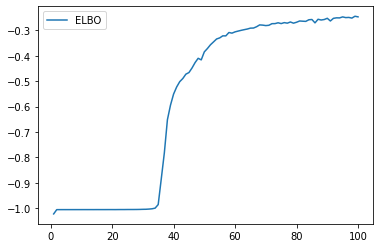

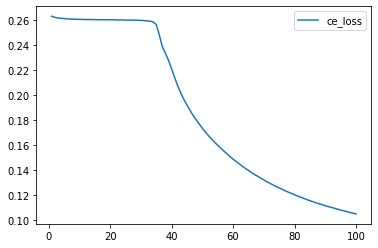

In [53]:
num_epochs = 100
elbo = []
cat_loss = []
for epoch in range(num_epochs):
    cat_loss_avg = 0.0
    elbo_avg = 0.0
    for mini_batch_index, mini_batch in enumerate(loader):
        data, label = mini_batch
        label = to_one_hot_vector(label, num_cluster)
        e_optimizer.zero_grad()
        c_optimizer.zero_grad()
        d_optimizer.zero_grad()
        z_mu, z_sig = encoder(data)
        z = sampling(z_mu, z_sig)
        kld_loss = kl_divergence_loss(z_mu, z_sig)
        hyp = classifier(z)
        ce_loss = (-label * torch.log(hyp)).mean()
        x_mu, x_sig = decoder(z)
        evidence_loss = nll_evidence_loss(x_mu, x_sig, data)
        loss = kld_loss + evidence_loss + ce_loss
        loss.backward()
        e_optimizer.step()
        c_optimizer.step()
        d_optimizer.step()
        elbo_avg += -(kld_loss + evidence_loss).item()
        cat_loss_avg += ce_loss.item()

    elbo.append(elbo_avg / len(loader))
    cat_loss.append(cat_loss_avg / len(loader))

plt.plot(np.arange(1, num_epochs + 1), elbo, label='ELBO')
plt.legend()
plt.show()
plt.plot(np.arange(1, num_epochs + 1), cat_loss, label='ce_loss')
plt.legend()
plt.show()

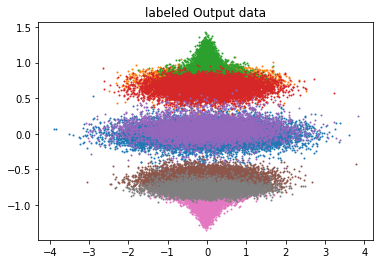

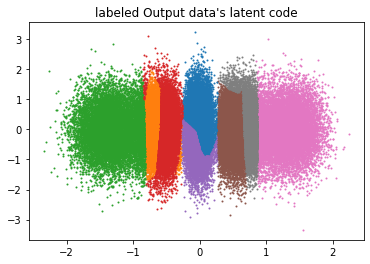

In [54]:
z_mu, z_sig = encoder(dataset.data)
z = sampling(z_mu, z_sig)
kld_loss = kl_divergence_loss(z_mu, z_sig)
pred_label = torch.argmax(classifier(z), dim=1)
x_mu, x_sig = decoder(z)
x = sampling(x_mu, x_sig)
group = []
latent = []
for k in range(num_cluster):
    group.append([])
    latent.append([])


recon_data = x.data.numpy()
latent_data = z.data.numpy()
pred_label = pred_label.numpy()

for i in range(num_data):
    group[pred_label[i]].append(recon_data[i])
    latent[pred_label[i]].append(latent_data[i])

for k in range(num_cluster):
    group[k] = np.array(group[k])
    latent[k] = np.array(latent[k])

plt.title("labeled Output data")
for k in range(num_cluster):
    if len(group[k]) != 0:
        plt.scatter(group[k][:, 0], group[k][:, 1], s = 1)
plt.show()

plt.title("labeled Output data's latent code")
for k in range(num_cluster):
    if len(latent[k]) != 0:
        plt.scatter(latent[k][:, 0], latent[k][:, 1], s = 1)
plt.show()
